In [ ]:
from google.colab import files
import pandas as pd
import numpy as np
import sklearn
import io

In [ ]:
# Upload the dataset
uploaded  = files.upload()
filename = next(iter(uploaded))
df = pd.read_csv(io.BytesIO(uploaded[filename]))
df

Saving diabetes.csv to diabetes.csv


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [ ]:
# Replacing the zeroes
df[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] = df[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].replace(0, np.NaN)

In [ ]:
# Using the KNN approach to fill in for the missing values
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[columns])
df_scaled = pd.DataFrame(df_scaled, columns = columns)
imputer = KNNImputer(n_neighbors = 5)
df_scaled_imputed = imputer.fit_transform(df_scaled)
df_scaled_imputed = pd.DataFrame(df_scaled_imputed, columns = columns)
df.update(df_scaled_imputed)

In [ ]:
# Preprocessing the dataset
# encoding the output as -1 or 1
# standardizing input features
# train a Logistic Regression Model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

df['Outcome'] = df['Outcome'].replace({0: -1, 1: 1})
features = df.columns.drop('Outcome')
df[features] = scaler.fit_transform(df[features])

x_train, x_test, y_train, y_test = train_test_split(df[features], df['Outcome'], test_size = 0.3, random_state = 0)
class_weights = {-1: 1, 1: 1}

model = LogisticRegression(class_weight = class_weights)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy of the Logistic Regression Model: ", accuracy)
print("Confusion Matrix: ", conf_matrix)

Accuracy of the Logistic Regression Model:  0.7619047619047619
Confusion Matrix:  [[140  17]
 [ 38  36]]


Accuracy:  0.7619047619047619
Confusion Matrix:
 [[140  17]
 [ 38  36]]
Precision:  0.6792452830188679
Recall:  0.4864864864864865
ROC_AUC:  0.8358581511447754


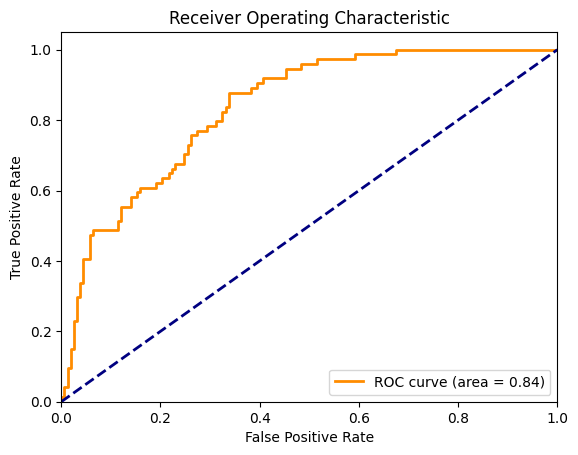

In [ ]:
from sklearn.metrics import precision_score, recall_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(x_test)[:, 1])
roc_auc = roc_auc_score(y_test, model.predict_proba(x_test)[:, 1])

print("Accuracy: ", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Precision: ", precision)
print("Recall: ", recall)
print("ROC_AUC: ", roc_auc)

plt.figure()
plt.plot(fpr, tpr, color = 'darkorange', lw = 2, label= 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc = "lower right")
plt.show()

In [ ]:
# Identifying how variables affect the outcomes
# Getting the coefficients of the features
feature_importance = pd.DataFrame(model.coef_[0], index = features, columns = ['Coefficient'])
print(feature_importance.sort_values(by = 'Coefficient', ascending = False))

                          Coefficient
Glucose                      1.118139
BMI                          0.675032
Pregnancies                  0.315078
Age                          0.263459
DiabetesPedigreeFunction     0.231654
Insulin                     -0.010895
SkinThickness               -0.024487
BloodPressure               -0.176999


In [ ]:
import requests
import zipfile

zip_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00296/dataset_diabetes.zip"
response = requests.get(zip_url)
if response.status_code == 200:
  with zipfile.ZipFile(io.BytesIO(response.content)) as thezip:
    with thezip.open('dataset_diabetes/diabetic_data.csv') as myfile:
      df_actual = pd.read_csv(myfile)
else: print("Failed to download the file")

In [ ]:
import seaborn as sns

df_actual['A1Cresult'] = df_actual['A1Cresult'].fillna('none')

# Grouping primary diagnosis codes into broader categories
def categorize_diag(diag):
  if diag.startswith('250'):
    return 'Diabetes'
  elif diag.startswith(('390', '459')):
    return 'Circulatory'
  elif diag.startswith(('460', '519')):
    return 'Respiratory'
  else: return 'Other'

df_actual['diag_group'] = df_actual['diag_1'].apply(categorize_diag)

In [ ]:
# Bivariate Analysis: HbA1c vs Medication Change
a1c_med_change = pd.crosstab(df_actual['A1Cresult'], df_actual['change'], normalize = 'index')
print("\nA1Cresult vs Medication Change:\n", a1c_med_change)


A1Cresult vs Medication Change:
 change           Ch        No
A1Cresult                    
>7         0.507608  0.492392
>8         0.651047  0.348953
Norm       0.442084  0.557916
none       0.442736  0.557264


In [ ]:
# Analysis: Measured vs Not Measured HbA1c and Medication change
df_actual['A1C_measured'] = df_actual['A1Cresult'].apply(lambda x: 'Measured' if x != 'none' else 'Not Measured')
a1c_measured_med_change = pd.crosstab(df_actual['A1Cresult'], df_actual['change'], normalize = 'index')
print("\nA1C measured vs Medication Change:\n", a1c_measured_med_change)


A1C measured vs Medication Change:
 change           Ch        No
A1Cresult                    
>7         0.507608  0.492392
>8         0.651047  0.348953
Norm       0.442084  0.557916
none       0.442736  0.557264


In [ ]:
# Analysis: Measured vs Not Measured HbA1c and Readmission
a1c_measured_read = pd.crosstab(df_actual['A1C_measured'], df_actual['readmitted'], normalize = 'index')
print("\nA1C Measured vs Readmission:\n", a1c_measured_read)


A1C Measured vs Readmission:
 readmitted         <30       >30        NO
A1C_measured                              
Measured      0.098484  0.340816  0.560700
Not Measured  0.114233  0.350982  0.534785


In [ ]:
# Trivariate Analysis: A1C Measured vs Readmission stratified by Primary Diagnosis
a1c_measured_read_diag = pd.crosstab([df_actual['A1C_measured'], df_actual['diag_group']], df_actual['readmitted'], normalize='index')
print("\nA1C Measured vs Readmission stratified by Primary Diagnosis:\n", a1c_measured_read_diag)


A1C Measured vs Readmission stratified by Primary Diagnosis:
 readmitted                     <30       >30        NO
A1C_measured diag_group                               
Measured     Circulatory  0.000000  0.500000  0.500000
             Diabetes     0.095428  0.339985  0.564586
             Other        0.099207  0.340939  0.559854
             Respiratory  0.000000  0.142857  0.857143
Not Measured Circulatory  0.094118  0.364706  0.541176
             Diabetes     0.145642  0.396767  0.457590
             Other        0.111850  0.347494  0.540656
             Respiratory  0.128205  0.307692  0.564103


Text(145.72222222222223, 0.5, 'HbA1c Result')

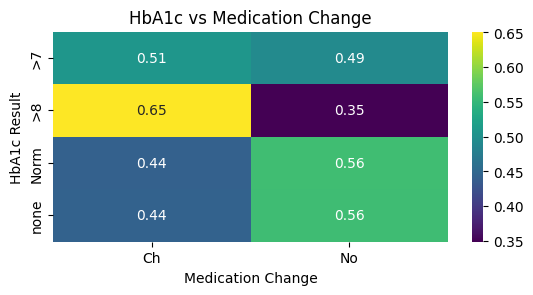

In [ ]:
plt.figure(figsize = (14, 6))

# Heatmap for HbA1c vs Medication Change
plt.subplot(2, 2, 1)
sns.heatmap(a1c_med_change, annot = True, cmap = 'viridis')
plt.title('HbA1c vs Medication Change')
plt.xlabel('Medication Change')
plt.ylabel('HbA1c Result')

Text(50.722222222222214, 0.5, 'HbA1c Result')

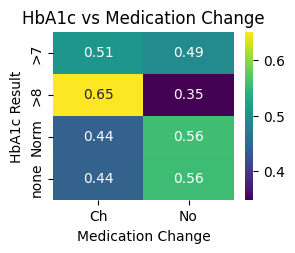

In [ ]:
# Heatmap for HbA1c vs Medication Change
plt.subplot(2, 2, 1)
sns.heatmap(a1c_med_change, annot = True, cmap = 'viridis')
plt.title('HbA1c vs Medication Change')
plt.xlabel('Medication Change')
plt.ylabel('HbA1c Result')

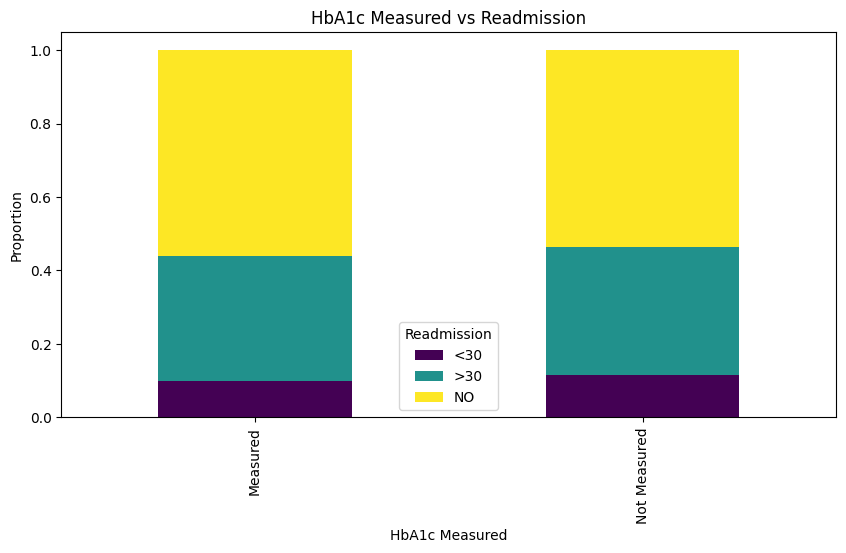

In [ ]:
# Clustered Bar Plot for HbA1c Measured vs Readmission
a1c_measured_read.plot(kind = 'bar', stacked = True, colormap = 'viridis', figsize = (10, 5))
plt.title('HbA1c Measured vs Readmission')
plt.xlabel('HbA1c Measured')
plt.ylabel('Proportion')
plt.legend(title = 'Readmission')
plt.show()

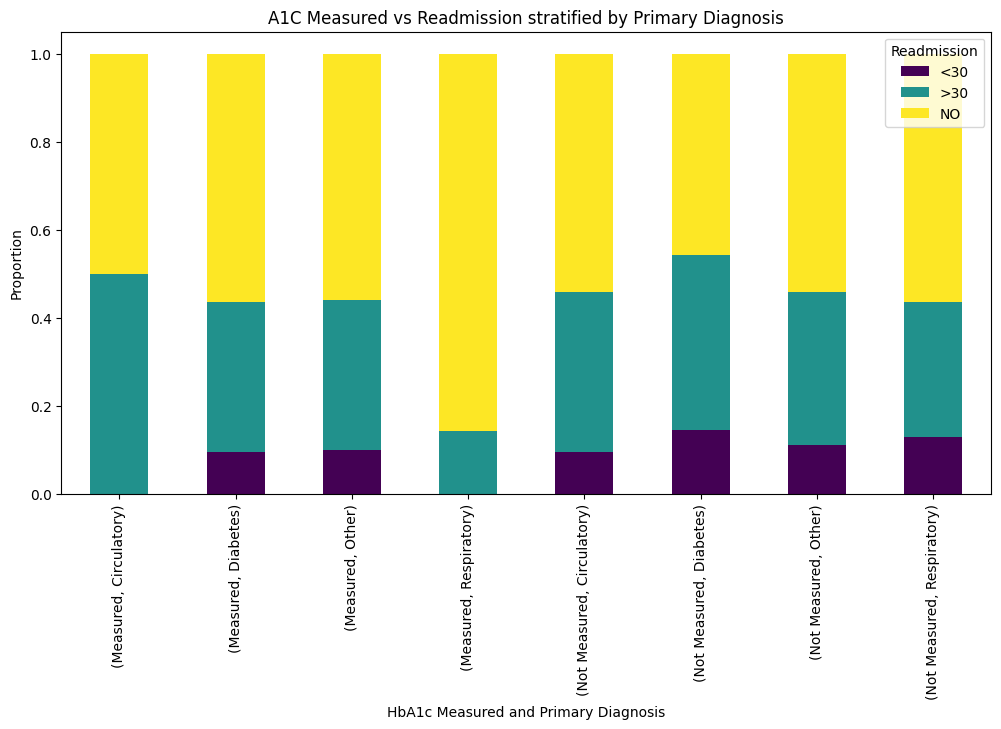

In [ ]:
# Clustered Bar Plot for A1C Measured vs Readmission stratified by Primary Diagnosis
a1c_measured_read_diag.plot(kind='bar', stacked=True, colormap='viridis', figsize=(12, 6))
plt.title('A1C Measured vs Readmission stratified by Primary Diagnosis')
plt.xlabel('HbA1c Measured and Primary Diagnosis')
plt.ylabel('Proportion')
plt.legend(title='Readmission')
plt.show()